In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import imutils
import pickle
from tqdm.auto import tqdm
from scipy import spatial
import vptree

In [5]:
### Query image####

In [13]:
ls miniData/Cubism

adolf-fleischmann_hommage-delaunay-et-gleizes-1938.jpg
afro_cronaca-autobiographia-1953.jpg
albert-gleizes_arabesque-brush-or-cubist-composition-1952.jpg
albert-gleizes_composition-1928.jpg
albert-gleizes_composition-au-diapason.jpg
albert-gleizes_composition-for-jazz-1915.jpg
albert-gleizes_femme-au-fauteuil-1923.jpg
albert-gleizes_femme-cubiste-1921.jpg
albert-gleizes_femmes-cousant-1913.jpg
albert-gleizes_figure-cubiste-1921.jpg
albert-gleizes_football-players-1912.jpg
albert-gleizes_houses-in-a-valley-1910.jpg
albert-gleizes_la-chasse-1911.jpg
albert-gleizes_landscape-with-bridge-and-viaduct-1910.jpg
albert-gleizes_landscape-with-chimneys-1913.jpg
albert-gleizes_landscape-with-mill.jpg
albert-gleizes_man-on-a-balcony-portrait-of-dr-th-o-morinaud-1912.jpg
albert-gleizes_mati-re-et-lumi-re-ou-le-christ-au-t-tramorphe-1934.jpg
albert-gleizes_new-york-1915.jpg
albert-gleizes_on-a-sailboat.jpg
albert-gleizes_paysage-1914.jpg
albert-gleizes_portrait-de-jacques-nayral-1911.jpg
vicente-man

In [61]:
query_path = 'miniData/Cubism/wifredo-lam_figure-blanche.jpg'
image = cv2.imread(query_path)


In [62]:
def gram_matrix(x):
    x = tf.transpose(x)
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    gram = tf.reshape(gram,(tf.shape(gram)[0], -1))
    return gram
def preprocess_image(image_path):
    width, height = keras.preprocessing.image.load_img('Data/Art_Nouveau_Modern/raphael-kirchner_santoy-1900-2.jpg').size
    img_nrows = 256
    img_ncols = int(width * img_nrows / height)
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)
def deprocess_image(x):
    width, height = keras.preprocessing.image.load_img('Data/Art_Nouveau_Modern/raphael-kirchner_santoy-1900-2.jpg').size
    img_nrows = 256
    img_ncols = int(width * img_nrows / height)
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [63]:
model = vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [64]:
def style_encoding(image_path,feature_extractor):
    image_tensor = preprocess_image(image_path)
    features = feature_extractor(image_tensor)
    layer_features = features['block5_pool']
    gram = gram_matrix(layer_features)
    gram = np.array(tf.reshape(gram, [-1]))
    return gram


def color_encoding(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    features = []
    (h, w) = image.shape[:2]
    (cX, cY) = (int(w * 0.5), int(h * 0.5))
    segments = [(0, cX, 0, cY), (cX, w, 0, cY), (cX, w, cY, h),(0, cX, cY, h)]
    
    (axesX, axesY) = (int(w * 0.75) // 2, int(h * 0.75) // 2)
    
    ellipMask = np.zeros(image.shape[:2], dtype = "uint8")
    
    cv2.ellipse(ellipMask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)
    
    for (startX, endX, startY, endY) in segments:
        
# construct a mask for each corner of the image, subtracting
# the elliptical center from it
        cornerMask = np.zeros(image.shape[:2], dtype = "uint8")
        cv2.rectangle(cornerMask, (startX, startY), (endX, endY), 255, -1)
        cornerMask = cv2.subtract(cornerMask, ellipMask)
        # extract a color histogram from the image, then update the
        # feature vector
        hist = histogram(image, mask = cornerMask)
        features.extend(hist)
    hist = histogram(image, ellipMask)
    features.extend(hist)
    return np.array(features)




def histogram(image, mask):
    # extract a 3D color histogram from the masked region of the
    # image, using the supplied number of bins per channel
    hist = cv2.calcHist([image], [0, 1, 2], mask, (8,10,9),
        [0, 180, 0, 256, 0, 256])
    # normalize the histogram if we are using OpenCV 2.4
    if imutils.is_cv2():
        hist = cv2.normalize(hist).flatten()
    # otherwise handle for OpenCV 3+
    else:
        hist = cv2.normalize(hist, hist).flatten()
    # return the histogram
    return hist

In [65]:

style_encs = style_encoding(query_path,feature_extractor)
color_encs = color_encoding(query_path)
encs = np.array(np.concatenate([style_encs,color_encs]),dtype = 'int')
# enc_dict['image_path'].append(os.path.join(folder_path,image))
# enc_dict['folder_path'].append(path)
# ti.append(color_end_time)
# enc_dict['encoding'].append(encs)

In [66]:
#### Defining distance measures


def cosine_similarity(vec1, vec2):
    return spatial.distance.cosine(vec1, vec2)
def euclidean(vec1,vec2):
    return spatial.distance.euclidean(vec1,vec2)

In [67]:
with open('vp_tree.txt', 'rb') as handle:
    vp_tree = pickle.load(handle)
with open('encoding_dict.txt', 'rb') as handle:
    encoding_dict = pickle.load(handle)
with open('path_hashes.txt', 'rb') as handle:
    hashes = pickle.load(handle)

In [68]:
results = vp_tree.get_n_nearest_neighbors(encs, 10)

In [69]:
hashes

{'[44  0 25 ...  0  0  0]': './miniData/Cubism/adolf-fleischmann_hommage-delaunay-et-gleizes-1938.jpg',
 '[1866   13  158 ...    0    0    0]': './miniData/Cubism/afro_cronaca-autobiographia-1953.jpg',
 '[4484   11  916 ...    0    0    0]': './miniData/Cubism/albert-gleizes_arabesque-brush-or-cubist-composition-1952.jpg',
 '[1148    0    0 ...    0    0    0]': './miniData/Cubism/albert-gleizes_composition-1928.jpg',
 '[3817    0    8 ...    0    0    0]': './miniData/Cubism/albert-gleizes_composition-au-diapason.jpg',
 '[2559   29  498 ...    0    0    0]': './miniData/Cubism/albert-gleizes_composition-for-jazz-1915.jpg',
 '[1633    0    4 ...    0    0    0]': './miniData/Cubism/albert-gleizes_femme-au-fauteuil-1923.jpg',
 '[128   0   0 ...   0   0   0]': './miniData/Cubism/albert-gleizes_femme-cubiste-1921.jpg',
 '[21941   158   266 ...     0     0     0]': './miniData/Cubism/albert-gleizes_femmes-cousant-1913.jpg',
 '[5 0 0 ... 0 0 0]': './miniData/Cubism/albert-gleizes_figure-cub

In [70]:
results

[(0.0, array([1217,    0,  171, ...,    0,    0,    0])),
 (445650.6938825519, array([557,  21,  17, ...,   0,   0,   0])),
 (478276.54358958476, array([1501,    0,   49, ...,    0,    0,    0])),
 (483685.9952107359, array([1636,    0,  514, ...,    0,    0,    0])),
 (498083.36227282276, array([426,   0, 596, ...,   0,   0,   0])),
 (510932.265464807, array([3179,    1, 1007, ...,    0,    0,    0])),
 (511658.9450894023, array([1458,   30,    0, ...,    0,    0,    0])),
 (518796.10907272616, array([1703,    0,  170, ...,    0,    0,    0])),
 (519166.9674651884, array([642,   4,   0, ...,   0,   0,   0])),
 (537705.1383462873, array([479,   0,  89, ...,   0,   0,   0]))]

(<matplotlib.image.AxesImage at 0x7fb45b28f278>,
 './miniData/Cubism/wifredo-lam_figure-blanche.jpg')

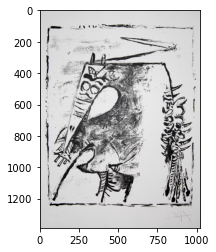

In [72]:
plt.imshow(cv2.imread(hashes[str(results[0][1])])),hashes[str(results[0][1])]

(<matplotlib.image.AxesImage at 0x7fb454eee128>,
 './miniData/Early_Renaissance/andrea-del-castagno_piet.jpg')

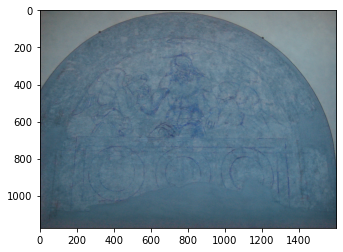

In [80]:
plt.imshow(cv2.imread(hashes[str(results[5][1])])),hashes[str(results[5][1])]